In [1]:
# Ian Álvarez
# Javier de la Cruz

In [1]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy.signal as sg
import random
from tkinter import *
# gráficos en el notebook
%matplotlib inline

In [2]:
%%writefile const.py
CHUNK = 1024
SRATE = 48000
TIME = SRATE
TEST_TIME = SRATE*3

notas = {
    'C': 523.251,   # do
    'D': 587.33,    # re
    'E': 659.255,   # mi
    'F': 698.456,   # fa
    'G': 783.991,   # sol
    'A': 880,       # la
    'B': 987.767,   # si
    'c': 1046.502,  # do
    'd': 1174.659,  # re
    'e': 1318.51,   # mi
    'f': 1396.913,  # fa
    'g': 1567.982,  # sol
    'a': 1760,      # la
    'b': 1975.533,  # si
}


Overwriting const.py


In [4]:
%%writefile osc.py

import numpy as np
import scipy.signal as sg
from const import *

# clase abstacta oscilador
class Osc:
    def __init__(self, freq, shape, amp=1.0, phase=0.0, chunk=CHUNK, samplerate=SRATE):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.samplerate = samplerate
        self.chunk = chunk
        self.onda = shape
        self.frame = 0
      
    def setFreq(self, freq):
        self.freq = freq
        
    def setChunk(self, chunk):
        self.chunk = chunk
      
    def setAmp(self, amp):
        self.amp = amp
      
    def getFreq(self):
        return self.freq

    def getAmp(self):
        return self.amp
    
    def getChunk(self):
        return self.chunk

    def next(self):
        onda = self.onda()
        self.frame += self.chunk
        return onda
  
class Sine(Osc):
    def __init__(self, freq, amp=1.0, phase=0.0, chunk=CHUNK, samplerate=SRATE):
        super().__init__(freq, self.sine, amp, phase, chunk, samplerate)

    def sine(self):
        tiempo = np.arange(self.frame, self.chunk + self.frame) # array con el tiempo
        onda = self.amp * np.sin(tiempo * (2 * np.pi * self.freq/self.samplerate) + self.phase)
        return onda


class Square(Osc):
    def __init__(self, freq, duty=0.5, amp=1.0, phase=0.0, chunk=CHUNK, samplerate=SRATE):
        super().__init__(freq, self.square, amp, phase, chunk, samplerate)
        self.duty = duty

    def square(self):
        # duty no está implementado
        tiempo = np.arange(self.frame, self.chunk + self.frame) # array con el tiempo
        # onda = np.where((tiempo - self.phase) * self.freq/self.samplerate % 1 < self.duty, self.amp, -self.amp)
        onda = self.amp * sg.square((2*np.pi * tiempo) * self.freq / self.samplerate + self.phase)
        return np.float32(onda)


class Triangle(Osc):
    def __init__(self, freq, amp=1.0, phase=0.0, chunk=CHUNK, samplerate=SRATE):
        super().__init__(freq, self.triangle, amp, phase, chunk, samplerate)

    def triangle(self):
        tiempo = np.arange(self.frame, self.chunk + self.frame) # array con el tiempo
        onda = (2 * self.amp / np.pi) * np.arcsin(np.sin(tiempo * (2 * np.pi * self.freq/self.samplerate) + self.phase))
        return onda


class Sawtooth(Osc):
    def __init__(self, freq, amp=1.0, phase=0.0, chunk=CHUNK, samplerate=SRATE):
        super().__init__(freq, self.sawtooth, amp, phase, chunk, samplerate)

    def sawtooth(self):
        tiempo = np.arange(self.frame, self.chunk + self.frame) # array con el tiempo
        onda = (2 * self.amp / np.pi) * np.arctan(np.tan(tiempo * (1 * np.pi * self.freq/self.samplerate) + self.phase))
        # si pongo 2 * np.pi...,(como dice wikipedia) creo que sale al doble de frecuencia de lo que debería
        return onda

class Kick(Osc):
    def __init__(self, freq, amp=1.0, phase=0.0, chunk=CHUNK, samplerate=SRATE, bpm=130, beat=0., dur = 1.):
        super().__init__(freq, self.kick, amp, phase, chunk, samplerate)
        self.bpm = bpm
        self.beat = beat % 4
        time = self.samplerate*60/self.bpm
        self.frame = int(time / 4 * beat)
        self.dur = dur

    # def kick(self):
    #     freq = self.freq
    #     time = self.samplerate*60/self.bpm
    #     if (self.frame > time):
    #         self.frame = 0
    #     tiempo = np.arange(self.frame, self.chunk + self.frame)
    #     onda = self.amp * np.sin(time * (np.pi * self.freq/self.samplerate)/(tiempo+.1) + self.phase)
    #     return onda
    
    def kick(self):
        freq = self.freq
        time = self.samplerate*60/self.bpm
        tiempo = np.zeros(0)
        if (self.chunk + self.frame >= time):
            t1 = np.arange(self.frame, time)
            t2 = np.arange(0, self.chunk - len(t1))
            self.frame -= time
            
            tiempo = np.concatenate((t1, t2))
        else:
            tiempo = np.arange(self.frame, self.chunk + self.frame)
            
        
        onda = np.sin((self.samplerate / self.dur) * (np.pi * self.freq/self.samplerate)/(tiempo+.1) + self.phase)
        return onda * self.amp
  
class HarmOsc(Osc):
    def __init__(self, freq, amps, shapes, amp=1.0, phase=0.0, chunk=CHUNK, samplerate=SRATE, norm=True):
        super().__init__(freq, self.harmOsc, amp, phase, chunk, samplerate)        
        # añade a shapes shapes[0] si el tamaño de shapes es menor que el de amps hasta que tengan el mismo tamaño
        if len(shapes) < len(amps):
            shapes = shapes + [shapes[0]] * (len(amps) - len(shapes))
        self.ondas = []
        for a in range(len(amps)):
            self.ondas.append(shapes[a](freq * (a + 1), amp=amps[a], phase=phase , chunk=chunk, samplerate=samplerate))
        self.norm = norm

    def setFreq(self, freq):
      # hay que cambiar las frecuencias 1 a una para cada onda
        self.freq = freq
        for o in range(len(self.ondas)):
            self.ondas[o].setFreq(freq * (o + 1))

    def harmOsc(self):
        harm = np.zeros(self.chunk)
        for o in self.ondas:
            harm = harm + o.next()
        if self.norm:
            harm = harm /  max(np.max(harm), -np.min(harm))
        return harm * self.amp
      
      
class Sumador(Osc):
    def __init__(self, ondas, amp=1., chunk=CHUNK, samplerate=SRATE, norm=True):
        super().__init__(0, self.suma, amp, 0, chunk, samplerate) 
        self.ondas = ondas
        for o in self.ondas:
            o.setChunk = chunk
        self.norm = norm
        
    def suma(self):
        signal = np.zeros(self.chunk)
        for o in self.ondas:
            signal = signal + o.next()
        if self.norm:
            signal = signal / max(np.max(signal), -np.min(signal))
        return signal * self.amp
            
                 

Overwriting osc.py


hasta aqui la declaración de osciladores

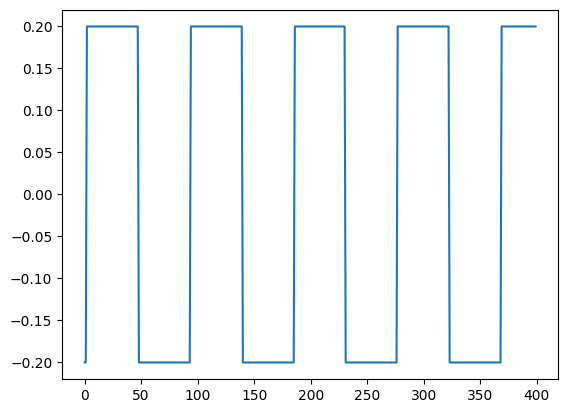

In [4]:
from osc import *
from const import *

la = Square(notas['C'], amp =.2, chunk=TIME)
la = la.next()
plt.plot(la[(CHUNK-200):(CHUNK+200)])
sd.play(la, samplerate=SRATE)
sd.wait()

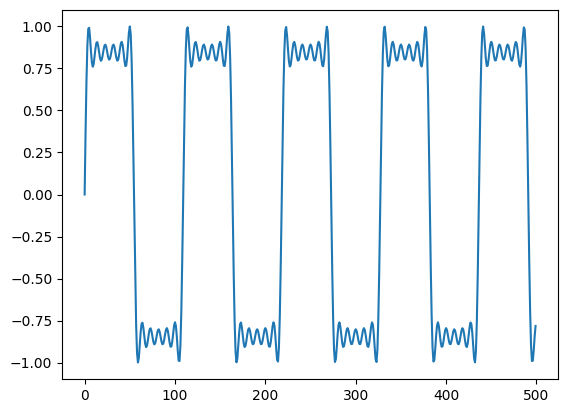

In [6]:
from osc import *
from const import *

# como usar harmosc
arm = [1, 0, 1/3, 0, 1/5, 0, 1/7, 0, 1/9, 0, 1/11]
la = HarmOsc(440, arm, [Sine], chunk = TIME)
la_t = la.next()
plt.plot(la_t[:500])
sd.play(la_t, samplerate=SRATE)
sd.wait()

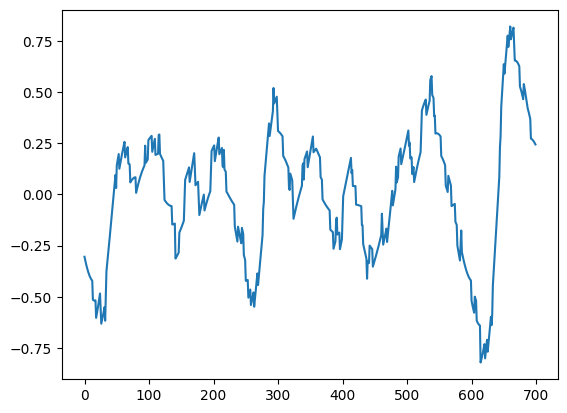

In [8]:
from osc import *
from const import *
# ORGANO / GAITA
segundos = 2
osc1 = HarmOsc(notas['C']/2, [1, .5, .2, .2], [Sine, Triangle, Square, Sawtooth], chunk=TIME)
osc2 = HarmOsc(notas['E']/2, [1, .5, .2, .2], [Sine, Triangle, Square, Sawtooth], chunk=TIME)
osc3 = HarmOsc(notas['G']/2, [1, .5, .2, .2], [Sine, Triangle, Square, Sawtooth], chunk=TIME)

onda1 = osc1.next()
onda2 = osc2.next()
onda3 = osc3.next()

DO = onda1 + onda2 + onda3

DO = DO / np.max(DO)
plt.plot(DO[(CHUNK-200):(CHUNK+500)])
sd.play(DO, samplerate=SRATE)
sd.wait()

In [9]:
from osc import *
from const import *
import random
# star wars simulator (en windows no funciona :/)
bpm_ = 130*4
for i in range(20):
    bpm = bpm_
    note = random.choice(list(notas.values()))*(random.random() + .5)
    # osc = Triangle(note, chunk=int(SRATE*60/bpm))
    input = HarmOsc(note, [random.random()+.5, 1/2, 1/3, 1/4, random.random()-.3], [Sine], chunk=int(SRATE*60/bpm))
    # bip = Osc(note, amp=0.9,amps=[random.random()+.5, 1/2, 1/3, 1/4, random.random()-.3], CHUNK=int(SRATE*60/bpm), shape='sine')
    bip = input.next()
    sd.play(bip, samplerate=SRATE)
    sd.wait()

bpm_ = 130*4
for i in range(20):
    bpm = bpm_
    note = random.choice(list(notas.values()))*(random.random() + 1)
    input = HarmOsc(note*2800, [random.random()+.5, 1/2, 1/3, 1/4, random.random()-.3], [Kick], chunk=int(SRATE*60/bpm))
    pew = input.next()
    sd.play(pew, samplerate=SRATE)
    sd.wait()


In [10]:
%%writefile modulator.py
from osc import *
from const import *
from modulator import *
from copy import copy
class Modulator:
    def __init__(self,signal,freq=1,v0=0.,v1=1.,srate=SRATE):
        self.signal = signal
        self.freq = freq
        self.v0 = v0
        self.v1 = v1
        self.t = 0
        self.srate = srate
    
    def next(self):
        # Generar el chunk de la señal original
        original_chunk = self.signal.next()
        
        # Generar la señal de modulación
        t = np.arange(self.t, self.t + len(original_chunk)) / self.srate
        modulation = (self.v1 - self.v0) / 2 * np.sin(2 * np.pi * self.freq * t) + (self.v1 + self.v0) / 2
        
        # Modulación de la señal original
        modulated_chunk = original_chunk * modulation
        
        # Actualizar el tiempo
        self.t += len(original_chunk)
        
        return modulated_chunk
    
class Modulator2:
    '''modula cualquier par de objetos osc'''
    def __init__(self, signal, shape, v0=0., v1=1., samplerate=SRATE, chunk=CHUNK):
        self.signal = signal
        self.shape = shape
        self.signal.setChunk(chunk)
        self.shape.setChunk(chunk)
        self.shape.setAmp((v1 - v0) / 2) # no va >:(
        # print(str(self.shape.getAmp()))
        self.v0 = v0
        self.v1 = v1
        self.samplerate = SRATE
        
    def next(self):
        original = self.signal.next()
        modulation = self.shape.next() + (self.v1 + self.v0) / 2
        # print(modulation[:29])
        modulated = original * modulation
        return modulated
        
        

Overwriting modulator.py


## 1.

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


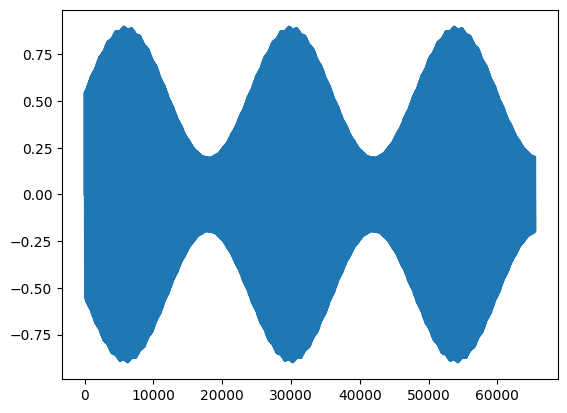

In [11]:
from osc import *
from const import *
from modulator import *
import matplotlib.pyplot as plt
import sounddevice as sd
# Señal que vamos a modular
signal = Triangle(440)
# Con un modulador de 2 Hz y amplitud en [0.2, 0.9]
mod = Modulator(signal, freq=2, v0=0.2, v1=0.9)
# Generamos 1.5 segundos de señal modulada
time = 1.5
chunks = int(time * 44100 / 1024) 
modulated_signal = np.empty(0)
for i in range(chunks):  # Generamos los chunks
    modulated_signal = np.append(modulated_signal, mod.next())

sd.play(modulated_signal)
plt.plot(modulated_signal)
plt.show()

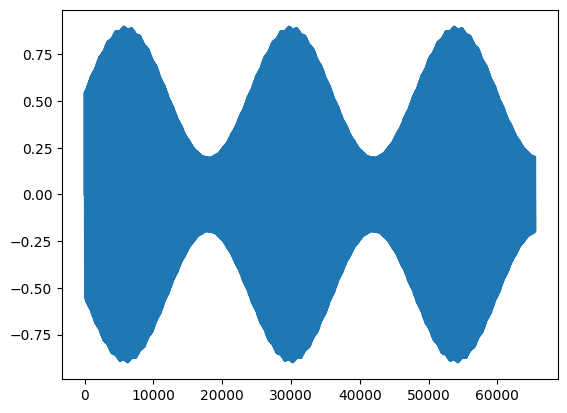

In [12]:
from osc import *
from const import *
from modulator import *
import matplotlib.pyplot as plt
import sounddevice as sd
# Señal que vamos a modular
signal1 = Triangle(440)
signal2 = Sine(2, amp=2)
# Con un modulador de 2 Hz y amplitud en [0.2, 0.9]
mod = Modulator2(signal1, signal2, v0=0.2, v1=0.9)
# Generamos 1.5 segundos de señal modulada
time = 1.5
chunks = int(time * 44100 / 1024) 
modulated_signal = np.empty(0)
m = np.empty(0)
for i in range(chunks):  # Generamos los chunks
    # m =  np.append(m,signal2.next())
    modulated_signal = np.append(modulated_signal, mod.next())


plt.plot(modulated_signal)
plt.plot(m)
plt.show()

sd.play(modulated_signal)
sd.wait()


## 2.

FUNCION PLAY VVVVVVVV

In [13]:
import sounddevice as sd
from const import *


''' Ahora en vez de sd.play, simplemente establecemos el valor de input como una de las clases osciladoras '''
input = None
def callback(outdata, frames, time, status):    
    global input
    #print('entro')
    if input is not None: 
        bloque = input.next()    
        outdata[:] = bloque.reshape(-1,1) # convertimos formato (CHUNK,) a (CHUNK,1) para que adecuarlo a sounddevice
    else:
        outdata[:] = np.zeros((CHUNK,1)) # si no hay datos, reproducimos silencio
            
# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, channels=2, callback=callback, blocksize=CHUNK)
stream.start()

In [ ]:
from modulator import *
from tkinter import *
import numpy as np   
from osc import *
import matplotlib.pyplot as plt
from const import *

In [ ]:
stream.start()

In [18]:
input = Sine(440)

In [19]:
input = HarmOsc(notas['C'], [1, .5, .2, .2], [Sine, Triangle, Square, Sawtooth], chunk=CHUNK)

In [20]:
bpm = 130

o1 = HarmOsc(notas['C']/4, [.8, .7, .2, .2], [Triangle, Sawtooth, Sawtooth, Square], chunk=CHUNK)
o2 = HarmOsc(notas['D']/8, [.8, .5, .2, .2], [Sine, Sawtooth, Square, Square], chunk=CHUNK, amp=.3)
o3 = HarmOsc(notas['G']/2, [.8, .5, .2, .2], [Sawtooth, Triangle, Square, Square], chunk=CHUNK)

o4 = Sine(notas['C'], amp=1)
o5 = Sine(notas['G'], amp=.3)

m1 = Modulator2(o1, Triangle((60/bpm)*16), v0=.3, v1=.8)

k1 = Kick(notas['C']/4, amp=2, bpm=bpm, phase=0, beat=0, dur=.2)
k15 = Kick(notas['C']/8, amp=1, bpm=bpm, phase=0, beat=0, dur=.9)
k2 = Kick(notas['D'], amp=1, bpm=bpm*2, phase=0, beat=2.7, dur=10)
k3 = Kick(notas['G'], amp=1.5, bpm=bpm, phase=0, beat=2.5, dur=10)
k4 = Kick(notas['g'], amp=1.5, bpm=bpm, phase=0, beat=1, dur=100)

input = Sumador([o2, m1, o4, k15, k1, k2, k3, k4], chunk=CHUNK, amp=1, norm=True)
# input = k3
s = np.zeros(0)
# for i in range(3*SRATE//CHUNK):
#     s = np.concatenate((s, input.next()))
# plt.plot(s)

In [22]:
input = None

In [23]:
from tkinter import *
import numpy as np
from osc import *
import matplotlib.pyplot as plt
from const import *

# inicialización de la ventanas
root = Tk()

# Caja de texto
text = Text(root, height=6, width=60)
text.pack(side=BOTTOM)
text.insert(
    INSERT, "f bajar frecuencia\n F subir frecuencia\n v Bajar volumen\n V subir volumen\n")

freq = 0
amp = .7

if input == None:
    input = Sine(440)


def key_down(event):
    _notas = "CDEFGABcdefgab"
    global freq
    global amp
    if event.char == 'f':
        freq -= 1
        if freq < 0:
            freq = 0
        print("Frecuencia bajada: freq = " + _notas[freq])
        input.setFreq(notas[_notas[freq]])
    elif event.char == 'F':
        freq += 1
        if freq > len(notas) - 1:
            freq = len(notas) - 1
        print("Frecuencia subida: freq = " + _notas[freq])
        input.setFreq(notas[_notas[freq]])
    elif event.char == 'v':
        amp -= .1
        if amp < 0:
            amp = 0
        print("Volumen bajado: vol = " + str(amp))
        input.setAmp(amp)
    elif event.char == 'V':
        amp += .1
        if amp > 1:
            amp = 1
        print("Volumen subido: vol = " + str(amp))
        input.setAmp(amp)


# enlace de la pulsación de teclas con la función key_down
text.bind('<Key>', key_down)


# arrancamos todo!!
root.mainloop()
# ejecución bloqueada hasta que se cierre ventana
input = None

Frecuencia bajada: freq = C
Frecuencia bajada: freq = C
Frecuencia bajada: freq = C
Frecuencia bajada: freq = C
Frecuencia bajada: freq = C
Frecuencia bajada: freq = C
Frecuencia subida: freq = D
Frecuencia subida: freq = E
Frecuencia subida: freq = F
Frecuencia subida: freq = G
Frecuencia subida: freq = A
Frecuencia subida: freq = B
Frecuencia subida: freq = c
Frecuencia bajada: freq = B
Frecuencia bajada: freq = A
Frecuencia bajada: freq = G
Frecuencia bajada: freq = F
Frecuencia subida: freq = G
Frecuencia subida: freq = A
Frecuencia bajada: freq = G
Frecuencia subida: freq = A
Frecuencia subida: freq = B
Frecuencia subida: freq = c
Frecuencia bajada: freq = B
Volumen bajado: vol = 0.6
Volumen bajado: vol = 0.5
Volumen bajado: vol = 0.4
Volumen bajado: vol = 0.30000000000000004
Volumen bajado: vol = 0.20000000000000004
Volumen bajado: vol = 0.10000000000000003
Volumen bajado: vol = 2.7755575615628914e-17
Volumen bajado: vol = 0
Volumen subido: vol = 0.1
Volumen subido: vol = 0.2
Vol

In [25]:
%%writefile oscFM.py
import numpy as np   
from osc import *
from const import *

class OscFM(Osc):
    def __init__(self,freq=110.0,amp=1.0,fm=6.0, beta=1.0, shapeMod=Sine, chunk=CHUNK, samplerate=SRATE):
        super().__init__(freq, self.oscfm, amp, 0, chunk, samplerate)
        # self.fm = fm     
        # self.beta = beta 
        # moduladora = βsin(2πfm)
        self.mod = shapeMod(freq=fm,amp=beta, chunk=chunk, samplerate=samplerate)
    
    def setBeta(self, beta):
        self.mod.setAmp(beta)
        
    def setFM(self, fm):
        self.mod.setFreq(fm)
        
    def getFM(self):
        return self.mod.getFreq()
    
    def getBeta(self):
        return self.mod.getAmp()
    
    def oscfm(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = self.mod.next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+self.chunk)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.freq*sample/self.samplerate + mod)
        # self.frame += self.chunk
        return out 

Overwriting oscFM.py


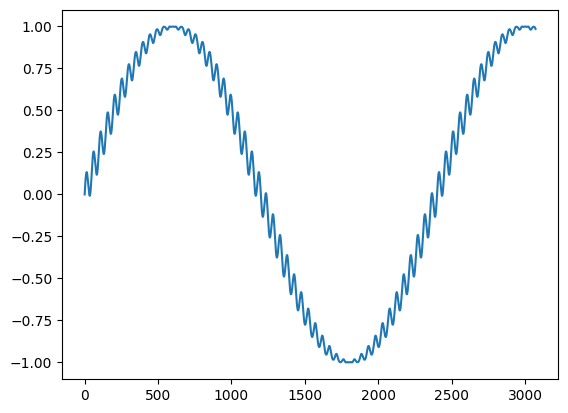

In [35]:
from oscFM import *
o = OscFM(20, chunk=CHUNK, fm=1000, beta=.1, shapeMod=Sine)
s = np.zeros(0)
for i in range(3*SRATE//CHUNK):
    s = np.concatenate((s, o.next()))
plt.plot(s[:CHUNK*3])
input = o
stream.start()

In [27]:
from tkinter import *
from oscFM import *
import sounddevice as sd
from osc import *
from const import *


# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, channels=2,
                         callback=callback, blocksize=CHUNK)

# inicialización de la ventanas
root = Tk()

# Caja de texto
text = Text(root, height=12, width=60)
text.pack(side=BOTTOM)
text.insert(INSERT, "f bajar frecuencia\n F subir frecuencia\n v Bajar volumen\n V subir volumen\n m Bajar FM\n M Subir FM\n b Bajar Beta\n B Subir Beta\n")

amp = .7
fm = 1000
beta = 0.1

input = OscFM(440, amp=amp, chunk=CHUNK, fm=fm, beta=beta)


def key_down(event):
    _notas = "CDEFGABcdefgab"
    global amp
    global beta
    global fm
    if event.char == 'f':
        print("Frecuencia bajada: freq = " + str(freq))
        input.setFreq(input.getFreq() - 10)
    elif event.char == 'F':
        print("Frecuencia subida: freq = " + str(freq))
        input.setFreq(input.getFreq() + 10)
    elif event.char == 'v':
        amp -= .1
        if amp < 0:
            amp = 0
        print("Volumen bajado: vol = " + str(amp))
        input.setAmp(amp)
    elif event.char == 'V':
        amp += .1
        if amp > 1:
            amp = 1
        print("Volumen subido: vol = " + str(amp))
        input.setAmp(amp)
    elif event.char == 'm':
        fm -= 10
        if fm < 0:
            fm = 0
        print("FM bajado: fm = " + str(fm))
        input.setFM(fm)
    elif event.char == 'M':
        fm += 10
        print("FM subido: fm = " + str(fm))
        input.setFM(fm)
    elif event.char == 'b':
        beta -= .1
        if beta < 0:
            beta = 0
        print("Beta bajado: beta = " + str(beta))
        input.setBeta(beta)
    elif event.char == 'B':
        beta += .1
        print("Beta subido: beta = " + str(beta))
        input.setBeta(beta)


# enlace de la pulsación de teclas con la función key_down
text.bind('<Key>', key_down)


# arrancamos todo!!
root.mainloop()
# ejecución bloqueada hasta que se cierre ventana
input = None

In [1]:
%%writefile effects.py

from const import *
import numpy as np
import math

class Echo:
    def __init__(self, osc, val=.5, time=1, samplerate=SRATE, restar=False):
        self.osc = osc
        self.val = val
        _time = int(time*samplerate)
        self.time = _time
        self.frame = 0
        self.anterior = np.zeros(_time)
        self.restar = restar

    def next(self):
        signal = self.osc.next()
        chunk = len(signal)
        resta = 1
        val = self.val
        # va un poco raro con restar = True
        if self.restar: 
            resta = math.sqrt(1-self.val) # pongo esto porque no se si hacer que sea 1 o 1-val
            val = math.sqrt(self.val)
        if self.frame + chunk <= self.time:  # si cabe
            signal = signal * resta + (self.anterior[self.frame:self.frame+chunk] * val)
            self.anterior[self.frame:self.frame+chunk] = signal
        else:
            rest = self.frame + chunk - self.time
            signal1 = signal[:self.time-self.frame] * resta + (self.anterior[self.frame:self.time] * self.val)
            signal2 = signal[self.time-self.frame:] * resta + (self.anterior[:rest] * self.val)
            signal = np.concatenate((signal1, signal2))
            self.anterior[self.frame:] = signal1
            self.anterior[:rest] = signal2
        self.frame = (self.frame + chunk) % self.time
        return signal
    
class Delay:
    def __init__(self, input, time=1, samplerate=SRATE):
        self.osc = input
        _time = int(time*samplerate)
        self.time = _time
        self.frame = 0
        self.mem = np.zeros(_time)

    def next(self):
        signal = self.osc.next()
        chunk = len(signal)
        # se tiene que ir llenando desde atras :/
        if self.frame + chunk < self.time:  # si cabe
            _s = self.mem[self.frame:self.frame + chunk].copy()
            self.mem[self.frame:self.frame + chunk] = signal
            signal = _s
        else:
            rest = self.frame + chunk - self.time
            # cabe = selt.time - self.frame
            signal1 = self.mem[:rest].copy()
            signal2 = self.mem[self.frame:].copy()
            self.mem[:rest] = signal[chunk-rest:] 
            self.mem[self.frame:] =  signal[:chunk-rest]
            
            # self.mem[rest:chunk+rest] = signal
            _s = np.concatenate((signal2, signal1))
            # print(len(signal1))
            # print(len(signal1))
            # print(len(signal))
        self.frame = (self.frame + chunk) % self.time
        return _s

Overwriting effects.py


onda modulada con un eco

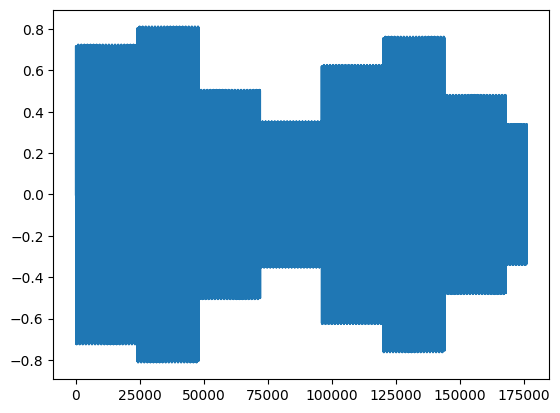

In [2]:
from oscFM import *
import sounddevice as sd
from osc import *
from const import *
from effects import *
from modulator import *
import matplotlib.pyplot as plt


# Señal que vamos a modular
signal1 = Triangle(440)
signal2 = Echo(Square(.5, amp=1), .5, .5, restar=True)
# Con un modulador de 2 Hz y amplitud en [0.2, 0.9]
mod = Modulator2(signal1, signal2, v0=0.2, v1=0.9)
# Generamos 4 segundos de señal modulada
time = 4
chunks = int(time * 44100 / 1024) 
modulated_signal = np.empty(0)
m = np.empty(0)
for i in range(chunks):  # Generamos los chunks
    # m =  np.append(m,signal2.next())
    modulated_signal = np.append(modulated_signal, mod.next())


plt.plot(modulated_signal)
plt.plot(m)
plt.show()

sd.play(modulated_signal)
sd.wait()

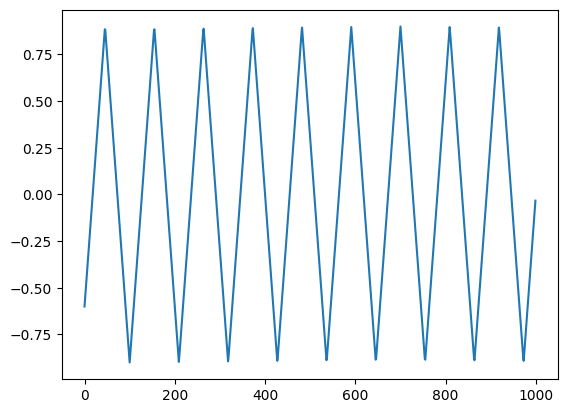

In [2]:
from oscFM import *
import sounddevice as sd
from osc import *
from const import *
from effects import *
from modulator import *
import matplotlib.pyplot as plt
# Señal que vamos a modular
signal1 = Triangle(440)
signal2 = Square(.5, amp=1)
# Con un modulador de 2 Hz y amplitud en [0.2, 0.9]
mod = Delay(Modulator2(signal1, signal2, v0=0.2, v1=0.9), 3)
# mod = Modulator2(signal1, signal2, v0=0.2, v1=0.9)

# Generamos 4 segundos de señal modulada
time = 8
chunks = int(time * 44100 / 1024) 
modulated_signal = np.empty(0)
m = np.empty(0)
for i in range(chunks):  # Generamos los chunks
    # m =  np.append(m,signal2.next())
    modulated_signal = np.append(modulated_signal, mod.next())


plt.plot(modulated_signal[6*SRATE-1000:6*SRATE])
plt.plot(m)
plt.show()

sd.play(modulated_signal)
sd.wait()